# **<center>Data Wrangling**

#### Import Packages

In [41]:
import os
import warnings

from tqdm import tqdm

import re
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Set Correct Options for the Notebook

In [2]:
# Show all the columns in the .head() method
pd.set_option('display.max_columns', None)
# Turn all plots dark to help my eyes
plt.style.use('dark_background')

The data was taken from kaggle and contains [Loan Data](https://www.kaggle.com/datasets/ranadeep/credit-risk-dataset?select=loan) information on the borrowers. Below I used Kaggle's API to download the dataset. I had trouble getting it to work inline in the notebook so I used these commands in the terminal.

In [3]:
'''
# Download the data from the kaggle api
kaggle datasets download -d ranadeep/credit-risk-dataset
# unzip the data 
unzip credit-risk-dataset.zip -d credit-risk-dataset 
'''

'\n# Download the data from the kaggle api\nkaggle datasets download -d ranadeep/credit-risk-dataset\n# unzip the data \nunzip credit-risk-dataset.zip -d credit-risk-dataset \n'

#### Set Directory

In [4]:
# Change notebook directory back one so that it can acess the data
os.chdir('..')

#### Load the Data

In [5]:
# Load in the data with low_memory as False so that it can understand dtype
loan = pd.read_csv('./data/raw/loan.csv', low_memory = False)
# Print out the shape of the dataset
print(loan.shape)
# Print out a sample of the dataset
loan.head()

(887379, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is large and complex. In the `read_csv()` function I had to specify `low_memory = False` because there were many too many different data types for the function to be able to determine the data type of each column. 

The first step is separate out the features (X) from the target variable (y). When I initially started this project I had believed that y was `loan_status` because it was listed on the kaggle website. After much data wrangling and looking closely at the dataset I realized that many of the features in the dataset did not lend themselves to `loan_status` being the target variable. Too many of the features appear to be taken after the loan originates. Since the original question that I was trying to ask was which loans are a good deal at the time of origination, I can't use features that are collected during the term of the loan. 

Instead I shifted the time frame to ask the question of how much money is expectected to be recouped during the time of the loan. That way I can use the information that was collected during the time of the loan and use the completed loans as training for the models while I try to predict the active loans. This can create a market or evaluation for the value of the existing loans and whether or not they are underperforming the grades that lending club gave. If the most important features are ones that were available at the time of origination then I can also audit Lending Club's grades.

In [6]:
# Create the features dataframe
X = loan.drop(['out_prncp', 'out_prncp_inv','total_pymnt', 'total_pymnt_inv',
               'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee','recoveries',
               'collection_recovery_fee'], axis = 1)
# Separate out the target variable
y = loan[['out_prncp', 'out_prncp_inv','total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
          'total_rec_int', 'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'loan_status']]

## Cleaning up the Dataset

#### Unique Values
The easiest part of the features to clean are ones that have only one values since there is no analysis that can be performed on them. Below I looked at how many unique values each feature has. I will drop every feature that has only 1 unique values.

In [7]:
X.nunique().sort_values(ascending = True)

policy_code                 1
pymnt_plan                  2
application_type            2
initial_list_status         2
term                        2
                        ...  
emp_title              299271
tot_cur_bal            327342
url                    887379
member_id              887379
id                     887379
Length: 65, dtype: int64

In [8]:
# Drop the 'policy_code' feature since there is only one policy code
X.drop('policy_code', axis = 1, inplace = True)

### Categorical Columns

In order to analyze the data, all of the data has to be in numeric values. The first step is to convert the categorical columns into numerical columns by either uncovering numerical values that they contain or by onehot encoding the non-numerical columns into binary features. Below I have printed out all of the non-numerical columns. 

In [9]:
# Use dtypes to find all of the columns that are not int or float in X
[X.dtypes.index[i] for i,type in enumerate(X.dtypes) if type not in ('int64','float64')]

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'application_type',
 'verification_status_joint']

Now I have a list that I can go one by one to convert to numerical or drop. The `term` variable represents how long loan is for and has two values: ` 36 months` and ` 60 months`. I can convert those strings to 3, and 5 respectively to represent the years.

In [10]:
# replace the string values with numerical values, use a dictionary to be concise
X['term'] = X['term'].replace({' 36 months':3, ' 60 months':5})
# Show the column
X['term']

0         3
1         5
2         3
3         3
4         5
         ..
887374    3
887375    3
887376    5
887377    5
887378    3
Name: term, Length: 887379, dtype: int64

Grade is categorical variable that can be changed to a numerical variable. First I need to see what are all the possible grades are, then transfer them to numerical form, then add the subgrade to create a full grade

In [11]:
# Show all the different possible grades
X['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

There is also the subgrade column which differentiates the quality of loans within the different grades. Since there are 5 subgrades for each grade, I can convert the subgrade to .2 downgrade of the grade

In [12]:
# Convert the grades into numbers that can be analyzed
X['grade'] = X['grade'].replace({'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1})
# Add in the subgrade as a .2 change in the grade
X['grade'] = [X['grade'][i] - ((int(sub[-1]) - 1)/5) for i, sub in enumerate(X['sub_grade'])]
# Show the grade
X['grade']

0         5.8
1         4.4
2         4.2
3         5.0
4         5.2
         ... 
887374    5.2
887375    5.2
887376    3.8
887377    2.6
887378    5.2
Name: grade, Length: 887379, dtype: float64

I can convert the employement status to an integer since it represents a numerical quantity. First I need to see all the values.

In [13]:
# Show all of the different employement lengths
X['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

Now I can replace all of those values with numerical values instead.

In [14]:
# Replace the non-existant values with 0
X['emp_length'] = X['emp_length'].fillna(0)
# Replace the less than one year with the average of .5
X['emp_length'] = X['emp_length'].replace('< 1 year', 0.5)
# Get rid of all non-numerical characters to convert the values into numerical
X['emp_length'] = X['emp_length'].replace(r'[a-zA-Z+]', '', regex = True)
# Change the type from string to numerical
X['emp_length'] = X['emp_length'].astype('float')

In [15]:
# Show the new employment length column
X['emp_length']

0         10.0
1          0.5
2         10.0
3         10.0
4          1.0
          ... 
887374     8.0
887375    10.0
887376     5.0
887377     1.0
887378    10.0
Name: emp_length, Length: 887379, dtype: float64

In [16]:
# Look at all the types of home ownership
X['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [17]:
# Switch home_ownership rare values to other.
X['home_ownership'].replace({'NONE': 'OTHER','ANY':'OTHER'}, inplace = True)

In [18]:
# View all the unique reasons for why people are getting a loan.
X['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

The URL column appears to be a website with the id column at the end of it. I can test this by trying to see if the first 61 characters are always the same.

In [20]:
# Grab the first part of the url and see if it always the same.
X['url'].str[:61].unique()

array(['https://www.lendingclub.com/browse/loanDetail.action?loan_id='],
      dtype=object)

See if there is a difference between the end of the url and the id column.

In [21]:
# subtract the set of the id part of the url column from the id column.
set(X['id']) - set(X['url'].str.replace(r'\D+', '', regex = True).astype('int'))

set()

In [22]:
# find all the different types of jobs that the borrower could have
print(len(X['emp_title'].value_counts()[X['emp_title'].value_counts() > 1000]))
# See how common each of the different employment types
X['emp_title'].value_counts()[X['emp_title'].value_counts() > 1000]

48


Teacher                     13469
Manager                     11240
Registered Nurse             5525
Owner                        5376
RN                           5355
Supervisor                   4983
Sales                        4212
Project Manager              3988
Driver                       3569
Office Manager               3510
General Manager              3178
Director                     3156
manager                      3138
teacher                      2925
owner                        2849
Engineer                     2671
President                    2598
driver                       2429
Vice President               2351
Attorney                     2136
Operations Manager           2071
Accountant                   2035
Administrative Assistant     2019
Sales Manager                1846
Account Manager              1725
sales                        1724
Police Officer               1720
supervisor                   1675
Executive Assistant          1603
Analyst       

What stands out in this column is that many of the employment types seem to be variations on the same profession. For instance there are a lot of different kinds of managers even though they are all in the managerial profession. I can combine all of these to create a much more consolidated column.

In [150]:
Professions = {'Manager':['manag','supervisor','superintendent', 'lead', 'foreman'], 
               'Healer':['nurse', 'nursing', 'cna', 'lpn', 'physician', 'doctor', 'pharmacist', 'counselor', 'therapist', 'rn', 'paramedic'],
               'Technical': ['engineer','mechanic', 'electrician', 'machinist', 'machining', 'technician', 'it', 'software', 'tech','welder'], 
               'Executive':['president', 'owner', 'ceo', 'partner', 'vp'], 'Designer': ['designer'],
               'Vol': ['firefighter', 'social worker', 'army', 'officer', 'sheriff', 'deputy', 'sergeant', 'agent', 'colonel','USAF'],
               'Director':['director', 'coordinator'], 'Accountant':['accountant', 'bookkeeper', 'controller','accounting'], 'Sales':['sales', 'realt'], 
               'Finance':['financial','underwriter', 'broker', 'cfo','bank'], 'Analyst':['analyst','consult', 'analysis','estimator'], 
               'Clergy':['pastor','rabbi','priest', 'imam', 'minister'], 'Clerk':['clerk'],
               'Service':['bartender', 'server', 'service', 'diner', 'grill', 'attendant', 'cashier','aesthetician', 'dealer', 'cook','chef'], 
               'Manlab':['maintenance','maintenence','laborer','lumber', 'custodian','carpenter'],
               'Operator':['operator','pilot', 'driver'], 'Assistant':['assistant', 'secretary','receptionist'], 'Law':['attorney','esq','paralegal'],
               'Education':['teacher','principal','professor','school','educator'], 'Admin':['admin']}

In [151]:
# Fill in the missing values with unemployed for analysis
X['emp_title_cons'] = X['emp_title'].fillna('Unemployed')
for key, value in tqdm(Professions.items()):
    for v in value:
        # Create a boolean mask for all employments that are managerial
        prof = X['emp_title_cons'].str.contains(v, case=False)
        # Change the value of those to 'Manager'
        X.loc[prof, 'emp_title_cons'] = key

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


In [157]:
# find all the different types of jobs that the borrower could have
print(len(X['emp_title_cons'].value_counts()[X['emp_title_cons'].value_counts() > 1000]))
# See how common each of the different employment types
common_proffs = X['emp_title_cons'].value_counts()[X['emp_title_cons'].value_counts() > 1000]

22


In [161]:
# Create a feature that has the most common profession types, store the rest as other.
X['emp_type'] = [x if x in common_proffs.index else 'other' for x in X['emp_title_cons']] 

In [260]:
reasons = {'School':['college', 'school', 'university', 'degree','student'], 'Debt Consolidation':['consolidat', 'pay off', 'paying off', 'debt'], 
           'No Reason Given':['none'], 'Credit Problems':['credit card', 'credit debt', 'credit'], 
           'Business':['business','company','marketing', 'investment'], 'Medical':['medical', 'drug','illness','disease','cancer', 'surgery'], 
           'House Related':['house', 'backyard','pool', 'home', 'kitchen', 'roof', 'yard', 'porch', 'bedroom','remodel', 'mortgage', 'floor'],
           'Car':['car', 'motorcycle','truck', 'vehicle'], 'Vacation':['vacation'], 'Funeral':['funeral']}

In [261]:
# Create a new feature with no missing values
X['debt_cons'] = X['desc'].fillna("none")
# Loop over the reasons dictionary to find the most prevalent reasons
for key, value in tqdm(reasons.items()):
    for v in value:
        # Create a boolean mask for all employments that are managerial
        debt_cons = X['debt_cons'].str.contains(v, case=False)
        # Change the value of those to 'Manager'
        X.loc[debt_cons, 'debt_cons'] = key

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


In [262]:
len(X['debt_cons'].value_counts(normalize=True))

10015

In [277]:
# Look at the percentage of descriptions that are debt consolidation
common_reasons = X['debt_cons'].value_counts(normalize=True)[:9]

In [278]:
X['debt_cons'].value_counts(normalize=True)[:9]

No Reason Given       0.858025
Debt Consolidation    0.092733
Credit Problems       0.013751
School                0.008208
House Related         0.008008
Business              0.003333
Car                   0.002922
Medical               0.000991
Vacation              0.000399
Name: debt_cons, dtype: float64

In [279]:
common_reasons.index

Index(['No Reason Given', 'Debt Consolidation', 'Credit Problems', 'School',
       'House Related', 'Business', 'Car', 'Medical', 'Vacation'],
      dtype='object')

In [282]:
# Create a feature that has the most common profession types, store the rest as other.
X['reason'] = [x if x in common_reasons.index else 'other' for x in X['debt_cons']] 

In [283]:
# Convert all of the columns into dummy variables
X_num = pd.get_dummies(X, columns = ['home_ownership', 'verification_status', 'verification_status_joint', 'purpose','emp_type','reason'],
                      drop_first = True)

Columns to drop:
 - **id**: This is not a relational database so there is no value in having a variable that can tie this dataset to others.
 - **member_id**: same as ID, there are no other datasets for that need a bridge variable.
 - **url**: This column is f'https://www.lendingclub.com/browse/loanDetail.action?loan_id={id}' where id is the value of the ID column for the specific row
 - **emp_title:** There are too many employment titles. People confused job type with company name so dummy encoding would be a nightmare
 - **desc:** Too many reasons for loans. Without a large Language model to process them I don't know how to evaluate all the different descriptions

In [284]:
# drop all of the columns that I had mentioned earlier.
X_num.drop(['id', 'member_id', 'url', 'desc', 'emp_title', 'title', 
            'zip_code','addr_state','sub_grade','debt_cons', 'emp_title',
            'emp_title_cons'], axis = 1, inplace = True)

Binary columns to convert to binary variable.
- pymnt_plan: y if the borrower is on a payment plan, other isn't on a payment plan
- initial_list_status: W means that the loan is paid for in whole where as f is that it will be financed.
- application_type: 'Joint' indicates that the application is from the spouses. 

In [287]:
# Convert pyment_plan to a binary variable
X_num['pymnt_plan'] = np.where(X_num['pymnt_plan'] == 'y', 1, 0)
# Convert pyment_plan to a binary variable
X_num['initial_list_status'] = np.where(X_num['initial_list_status'] == 'w', 1, 0)
# Convert pyment_plan to a binary variable
X_num['application_type'] = np.where(X_num['application_type'] == 'JOINT', 1, 0)

#### Datetime rows

In [288]:
# Look at the type that the issue date column is
print(X_num['issue_d'].dtype)
# look at the first 5 values of the issue date.
X_num['issue_d'].head()

object


0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

In [289]:
# Convert the issue date to a datetime object
X_num['issue_d'] = pd.to_datetime(X_num['issue_d'], errors = 'coerce')

# Convert the earliest credit line of the borrower 
X_num['earliest_cr_line'] = pd.to_datetime(X_num['earliest_cr_line'], errors = 'coerce')

# Convert the last payment date of the loan
X_num['last_pymnt_d'] = pd.to_datetime(X_num['last_pymnt_d'], errors = 'coerce')

# Convert the next payment on the loan
X_num['next_pymnt_d'] = pd.to_datetime(X_num['next_pymnt_d'], errors = 'coerce')

# Convert the date that the lending company got a credit report
X_num['last_credit_pull_d'] = pd.to_datetime(X_num['last_credit_pull_d'], errors='coerce')

In [53]:
print(min(loan['issue_d']), max(loan['issue_d']))

Apr-2008 Sep-2015


In [40]:
X_num[['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']].isna().sum()/X_num.shape[0]

issue_d               0.000000
earliest_cr_line      0.000033
last_pymnt_d          0.019900
next_pymnt_d          0.285077
last_credit_pull_d    0.000060
dtype: float64

In [16]:
X_num = X_num.drop(['last_pymnt_d','next_pymnt_d'], axis = 1)

Convert the term column to years instead of a string defining the amount of months the loan is for

Create a dictionary with a description of all the different columns. The column names are sometimes unintuitive so it is helpful to have this dictionary.

In [15]:
# Disable warning that openpyxl generates that is impossible to get around
warnings.filterwarnings("ignore")
# Read the dictionary in to python saved as LCDD
LCDD = pd.read_excel('./data/raw/LCDataDictionary.xlsx')
# Turn Warnings back on for the rest of the notebook
warnings.filterwarnings("always")
# Create the dictionary with the columns as keys and the descriptions as values
col_defs = dict(zip(LCDD['LoanStatNew'],LCDD['Description']))
# Show the dictionary
col_defs

{'addr_state': 'The state provided by the borrower in the loan application',
 'annual_inc': 'The self-reported annual income provided by the borrower during registration.',
 'annual_inc_joint': 'The combined self-reported annual income provided by the co-borrowers during registration',
 'application_type': 'Indicates whether the loan is an individual application or a joint application with two co-borrowers',
 'collection_recovery_fee': 'post charge off collection fee',
 'collections_12_mths_ex_med': 'Number of collections in 12 months excluding medical collections',
 'delinq_2yrs': "The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years",
 'desc': 'Loan description provided by the borrower',
 'dti': 'A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.',
 'dti_joint': "A ratio calculated

### Missing Values

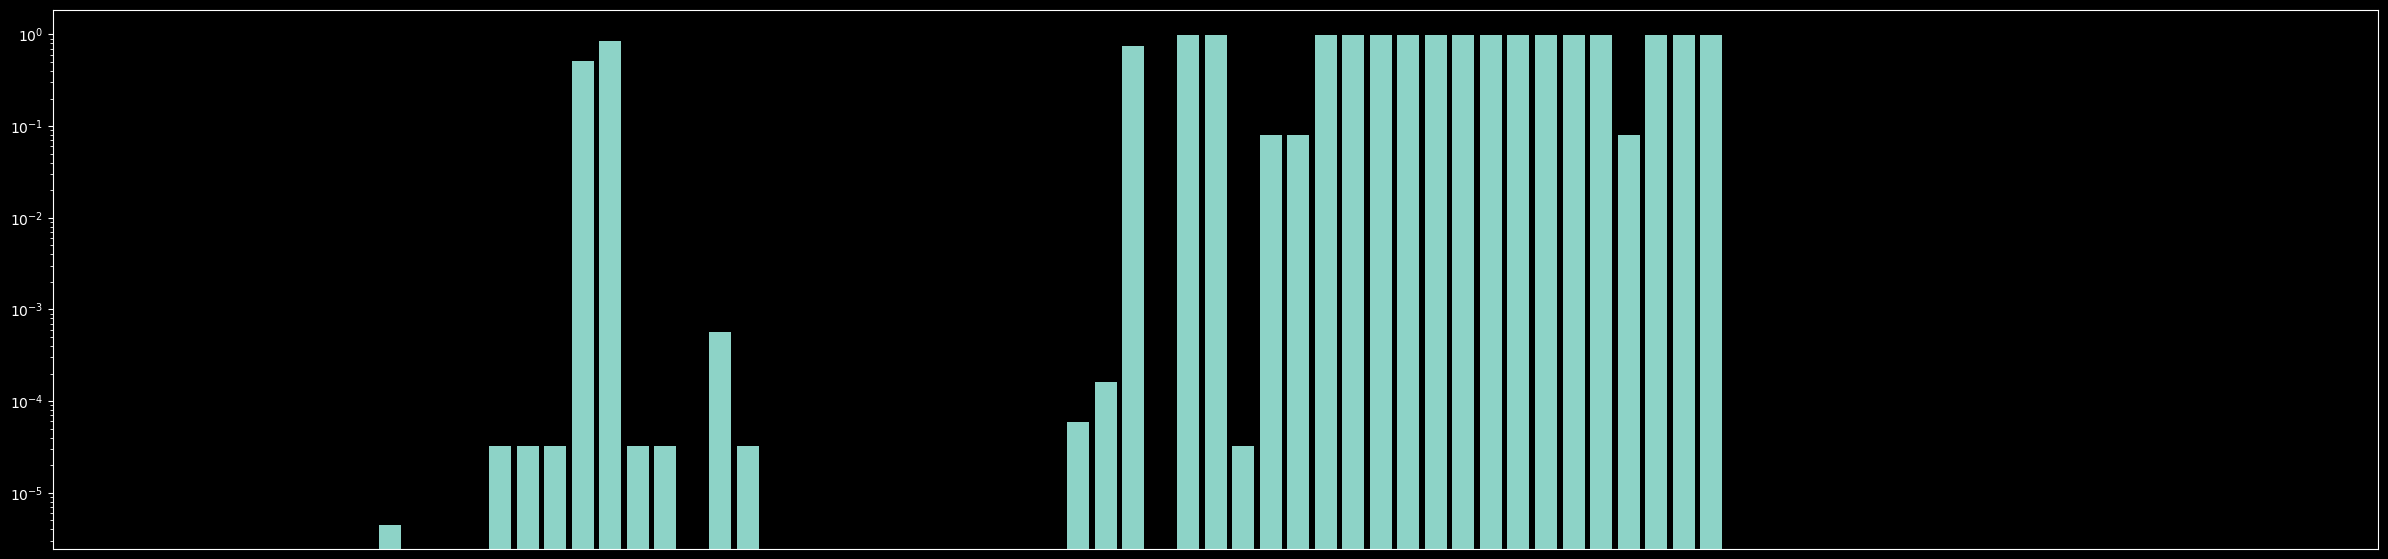

In [18]:
plt.figure(figsize = (30,7));
# Plot missing values for each column
plt.bar(x = X_num.columns, height = X_num.isna().sum()/X_num.shape[0])
# hide the names of the columns for a cleaner graph
plt.xticks([]);
# Set the scale to log so I can see every column that has a missing value
plt.yscale('log');

In [74]:
list(X_num.columns[X_num.isna().sum()/X_num.shape[0] > 0])

['annual_inc',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_util',
 'total_acc',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m']

The imputation of values for this dataset is the most challenging aspect of this project. There are many columns that have large swaths of missing values that need reasonable values filled in so as to allow the algorithms to capture the existing patterns in the data instead of artificial ones coming from synthetic data.

My assumption was that most missing values were zeroes that people forgot to fill out on forms or didn't bother with. For instance 'open_il_12m' refers to the number of opened installment accounts in the last 12 months. If there isn't any information on the number of installment accounts, then there likely aren't any installment accounts. 

Values such as 'mths_since_last_delinq' or months since last delinquent are different because if someone was never delinquent than the correct answer isn't 0 which would imply that they are currently delinquent but a very high number. The higher the value, the better the outcome on their loan. I can use 1000 since it is 83 years worth of non-delinquency.  

In [19]:
fill_with_zero = ['annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
                  'pub_rec', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
                  'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
                  'open_il_6m', 'open_il_12m', 'open_il_24m','total_bal_il', 'il_util',
                  'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim',
                  'inq_fi', 'total_cu_tl', 'inq_last_12m']

X_num[fill_with_zero] = X_num[fill_with_zero].fillna(0)

In [20]:
fill_with_1000 = ['mths_since_last_delinq', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'mths_since_rcnt_il']

X_num[fill_with_1000] = X_num[fill_with_1000].fillna(1000)

In [21]:
list(X_num.columns[X_num.isna().sum()/X_num.shape[0] > 0])

['earliest_cr_line', 'last_credit_pull_d', 'annual_inc_joint', 'dti_joint']

In [22]:
X_num['annual_inc'] = [loan['annual_inc'][i] if math.isnan(x) else x for i, x in enumerate(loan['annual_inc_joint'])]
X_num['inc_joint'] = np.where(loan['annual_inc_joint'].isnull(), 0, 1)

In [23]:
X_num['dti'] = [X_num['dti'][i] if math.isnan(x) else x for i, x in enumerate(X_num['dti_joint'])]
X_num['dti_joint'] = np.where(loan['dti_joint'].isnull(), 0, 1)

In [24]:
X_num['last_credit_pull_d'].fillna(pd.Timestamp('2016-01-01 00:00:00'), inplace = True)

In [25]:
X_num['earliest_cr_line'].fillna(pd.Timestamp('2016-01-01 00:00:00'), inplace = True)

In [26]:
list(X_num.columns[X_num.isna().sum()/X_num.shape[0] > 0])

['annual_inc', 'annual_inc_joint']

In [27]:
X_num.drop('annual_inc_joint', axis = 1, inplace = True)
X_num['annual_inc'].fillna(0, inplace = True)

#### Multicollinearity

In [28]:
# Function to get rid of all the diagonals in correlation heatmaps
def zero_diagonal_heatmap(dfx, min = 0, max = None, color_map = None, threshhold = 0):
    # give the max a base value
    if max is None:
        max = dfx.shape[1]
    # Create a numpy matrix that is easy to manipulate
    cm = np.array(abs(dfx.iloc[:,min:max].corr(numeric_only = False)))
    # Create a loop that replaces all the diagonal values with 0
    for i in range(len(cm)):
        # Loop thorough the other axis of values
        for j in range(len(cm)):
            # All diagonal values happen when i == j
            if i == j:
                # set the diagonal value equal to 0
                cm[i,j] = 0
    df_cm = pd.DataFrame(cm, columns = list(dfx.columns)[min:max], index = list(dfx.columns)[min:max])
    # Make the plot bigger
    plt.figure(figsize=(12, 8))
    # Plot the heatmap
    ax = sns.heatmap(df_cm, cmap = color_map, center = threshhold, vmin = 0, vmax = 1);

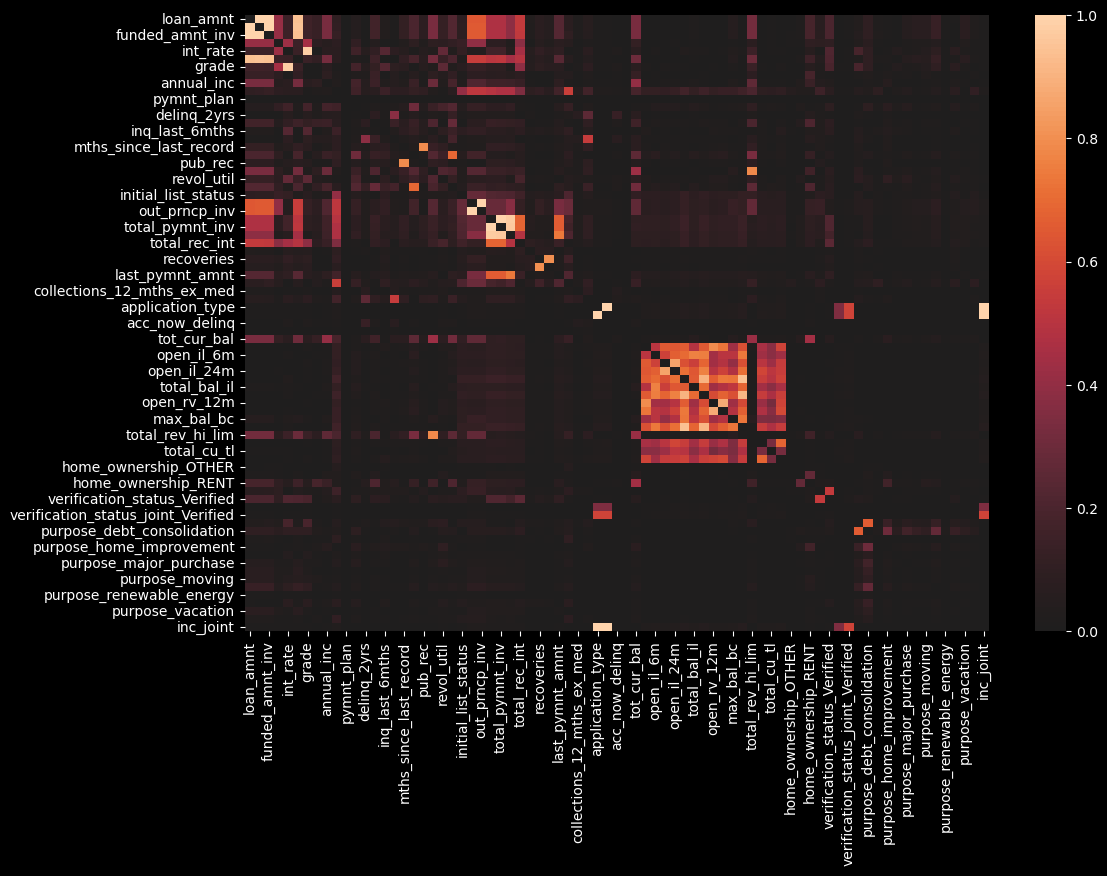

In [29]:
zero_diagonal_heatmap(X_num)

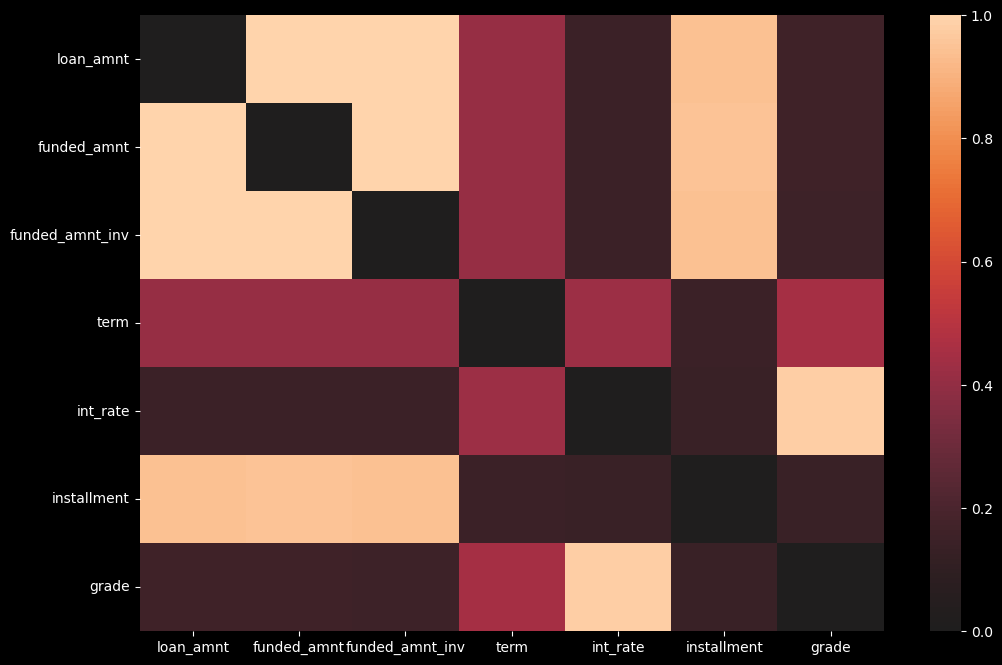

In [31]:
zero_diagonal_heatmap(X_num, 0, 7)

'loan_amnt' is the amount the requested amount of money for the loan from the borrower, 'funded_amnt' is the amount of money that has been committed to the loan, and 'funded_amnt_inv is the amount of money investors have committed to the loan. Since loan amount is the only variable that the applicant has control over, I believe it is the only relevant variable to keep. 'installment' is the monthly payment if the loan originates, this is a function of the loan amount and the term and can be dropped. 'int_rate' is the interest rate of the loan and it is directly determined by the grade that lending club gives the loan. I can pick one of the two and it will contain the information of the other.

In [32]:
X_num = X_num.drop(['funded_amnt','funded_amnt_inv', 'installment','int_rate'], axis = 1)

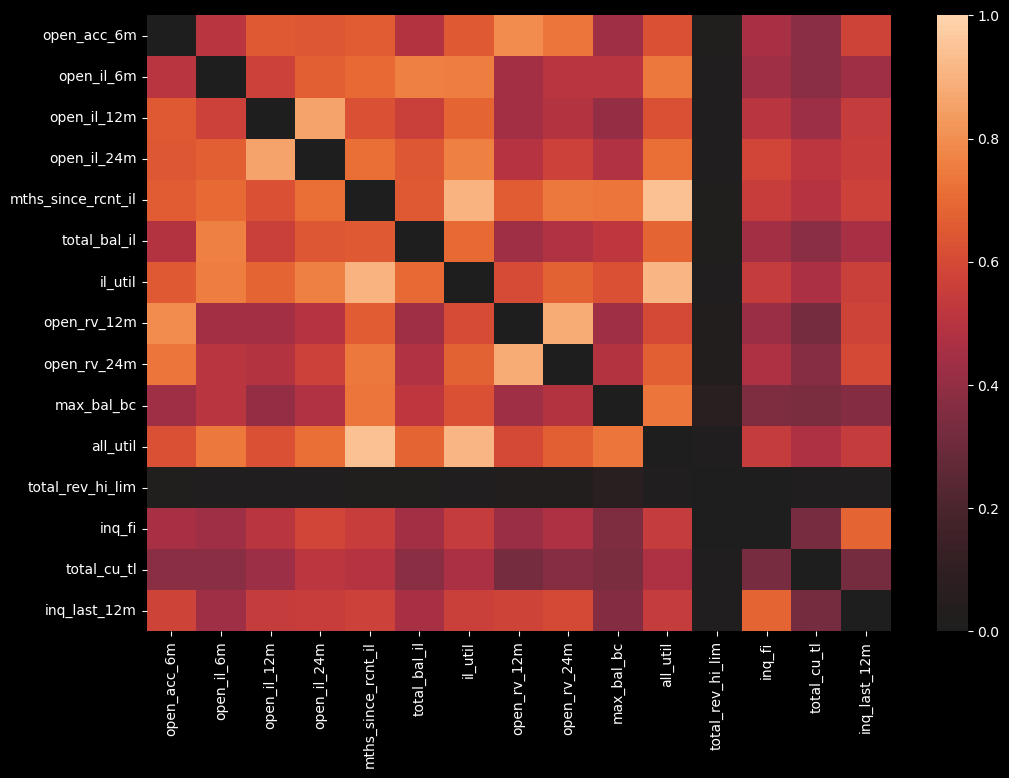

In [33]:
zero_diagonal_heatmap(X_num,37,52)

In [35]:
# Create a function that takes a dataframe and a correlation level 
def corr_dict(dfx, corr = 0.7):
    # Create the correlation with absolute values to measure collinearity
    corr_mat = abs(dfx.corr(numeric_only = False)) > corr   # type: ignore
    # Define the dictionary outside the function for uses
    global correl_dict
    # Create a dictionary with sorted values so that it is easy to see the next steps
    correl_dict = dict(corr_mat.sum().sort_values(ascending = False)) 
    # Subtract each value by one for the self correlation on the diagonal
    correl_dict = {key: value - 1 for key, value in correl_dict.items() if value != 1}
    # Print the dictionary
    print(correl_dict)

In [36]:
corr_dict(X_num)

{'all_util': 5, 'il_util': 5, 'mths_since_rcnt_il': 5, 'open_il_24m': 4, 'open_il_6m': 3, 'total_rec_prncp': 3, 'open_rv_24m': 3, 'inc_joint': 2, 'application_type': 2, 'dti_joint': 2, 'open_acc_6m': 2, 'total_pymnt_inv': 2, 'total_pymnt': 2, 'total_bal_il': 2, 'open_rv_12m': 2, 'max_bal_bc': 2, 'last_pymnt_amnt': 1, 'collection_recovery_fee': 1, 'recoveries': 1, 'open_il_12m': 1, 'total_rev_hi_lim': 1, 'out_prncp_inv': 1, 'mths_since_last_record': 1, 'revol_bal': 1, 'pub_rec': 1, 'out_prncp': 1}


In [37]:
# Create a function that takes a list of features and minimum number of correlations
def corr_list(min_corr, corr, still_high_mcl = None):
    # Define the dictionary where all the information will be stored
    correlations2 = {}
    # Almost always the default value will be None
    if still_high_mcl is None:
        # # the default list is the keys from correl_dict whose values are at least min_corr
        still_high_mcl = [key for key, value in correl_dict.items() if value >= min_corr]
    # Store the correlation matrix in a variable for easy use  
    still_corr = abs(X_num[still_high_mcl].corr())
    # Put the index and column names as the feature names
    still_corr.columns = still_high_mcl
    still_corr.index = still_high_mcl
    # Iterate through all the features in the list
    for shm in still_high_mcl:
        # create a list of all the features that have a correlation of over 7
        corrs2 = still_corr.index[still_corr[shm] > corr].tolist() #type: ignore
        # remove the self correlation
        corrs2.remove(shm)
        # input the feature and list into the dictionary
        correlations2.update({shm: corrs2})
    # print the result    
    print(correlations2)

In [38]:
corr_list(corr = 0.9, min_corr = 1)

{'all_util': ['il_util', 'mths_since_rcnt_il'], 'il_util': ['all_util', 'mths_since_rcnt_il'], 'mths_since_rcnt_il': ['all_util', 'il_util'], 'open_il_24m': [], 'open_il_6m': [], 'total_rec_prncp': ['total_pymnt_inv', 'total_pymnt'], 'open_rv_24m': [], 'inc_joint': ['application_type', 'dti_joint'], 'application_type': ['inc_joint', 'dti_joint'], 'dti_joint': ['inc_joint', 'application_type'], 'open_acc_6m': [], 'total_pymnt_inv': ['total_rec_prncp', 'total_pymnt'], 'total_pymnt': ['total_rec_prncp', 'total_pymnt_inv'], 'total_bal_il': [], 'open_rv_12m': [], 'max_bal_bc': [], 'last_pymnt_amnt': [], 'collection_recovery_fee': [], 'recoveries': [], 'open_il_12m': [], 'total_rev_hi_lim': [], 'out_prncp_inv': ['out_prncp'], 'mths_since_last_record': [], 'revol_bal': [], 'pub_rec': [], 'out_prncp': ['out_prncp_inv']}


In [39]:
X_num.drop(['all_util','il_util', 'total_rec_prncp', 'inc_joint', 'application_type', 'total_pymnt_inv', 'out_prncp_inv'], axis = 1, inplace = True)

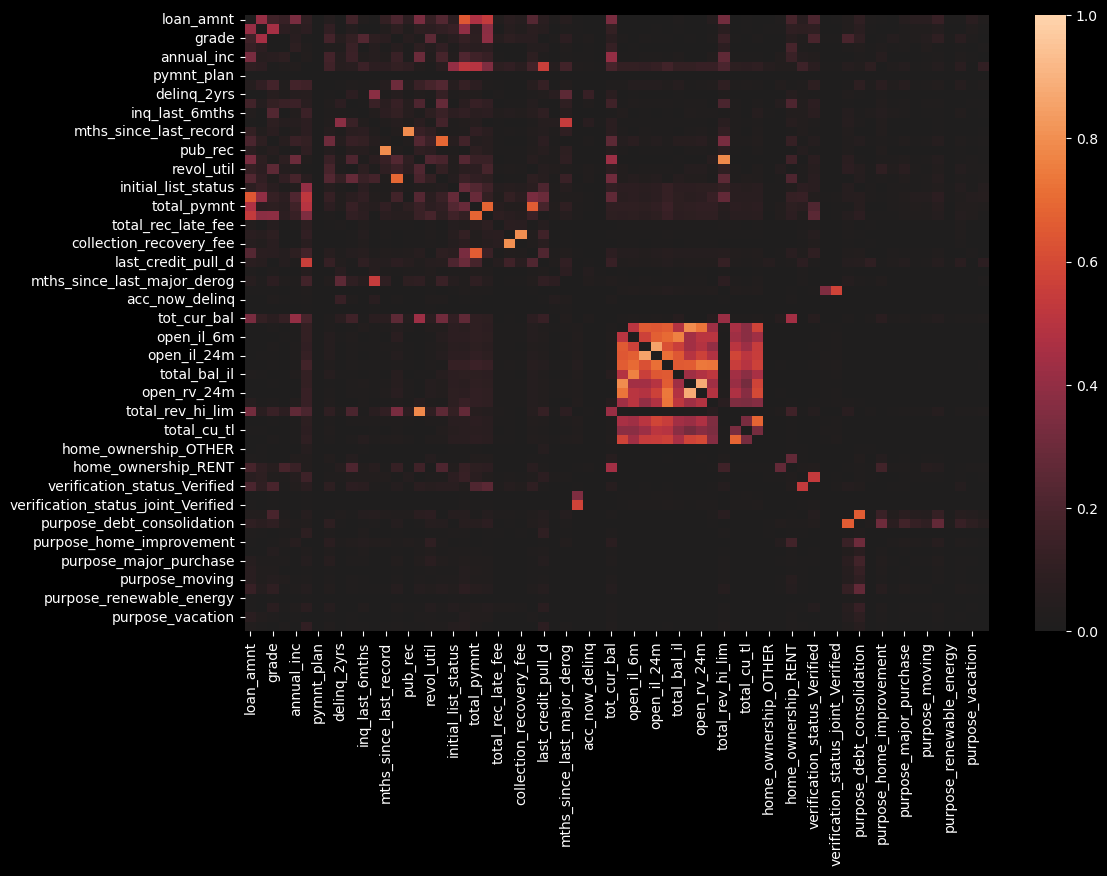

In [42]:
zero_diagonal_heatmap(X_num)

To make sure that I had fully eliminated the multicollinearity I calculated every remaining feature’s Variance Inflation Factor (VIF). The formula for VIF is:
$$VIF=\frac{1}{1-R^2}$$                                                  
Where ${R^2}$ is the R-squared value that represents correlations.   

In [43]:
# Create vif function with a dataframe as the argument
def vif(dfx):
    #calculate the vif for the dataframe to see if it is non collinear
    vifs = [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]
    # Put those numbers into a dictionary
    vif_dict = {dfx.columns[i]:vifs[i] for i in range(dfx.shape[1])}
    # Create a filtered dictionary to find out how many features have a VIF under 2.5
    filtered_dict = {k: v for k, v in vif_dict.items() if v < 2.5}
    # Print the amount of columns that aren't collinear out of all the columns
    print(f"{len(filtered_dict)} out of {len(dfx.columns)} features have a vif < 2.5")
    # Create a sorted dictionary based on the values
    vif_dict = {k:v for k, v in sorted(vif_dict.items(), key=lambda item: item[1], reverse = True)}
    # Print the result
    print(vif_dict)

In [52]:
vif(X_num.select_dtypes(include = 'number'))

36 out of 63 features have a vif < 2.5
{'loan_amnt': 56.26450845855685, 'term': 27.616372125278183, 'grade': 27.210087884343686, 'purpose_debt_consolidation': 19.86153486908927, 'total_pymnt': 16.773378162714856, 'purpose_credit_card': 15.431140991236324, 'out_prncp': 12.91289392617766, 'open_rv_12m': 6.030252223847061, 'total_rec_int': 5.582829100920188, 'open_il_24m': 5.535544332924983, 'open_rv_24m': 5.310111300261353, 'purpose_home_improvement': 5.293284078170711, 'purpose_other': 4.495668636776858, 'open_il_12m': 4.350463192885674, 'open_acc_6m': 3.8692675157899634, 'total_rev_hi_lim': 3.5743572757002346, 'emp_length': 3.5460114154982136, 'revol_bal': 3.5183504631838227, 'recoveries': 3.424020576048951, 'last_pymnt_amnt': 3.3972767864582187, 'annual_inc': 3.2661645528827368, 'open_il_6m': 2.907665476749993, 'collection_recovery_fee': 2.8705377099954035, 'total_bal_il': 2.7104066558059365, 'mths_since_last_record': 2.6498493903181313, 'mths_since_rcnt_il': 2.64265434626669, 'pub_re

In [56]:
corr_dict(X_num)

{'mths_since_rcnt_il': 3, 'open_rv_24m': 3, 'open_acc_6m': 2, 'open_rv_12m': 2, 'open_il_24m': 2, 'max_bal_bc': 1, 'mths_since_last_record': 1, 'total_rev_hi_lim': 1, 'revol_bal': 1, 'pub_rec': 1, 'recoveries': 1, 'collection_recovery_fee': 1, 'total_bal_il': 1, 'open_il_6m': 1, 'open_il_12m': 1}


In [57]:
corr_list(corr= .7, min_corr = 2)

{'mths_since_rcnt_il': ['open_rv_24m', 'open_il_24m'], 'open_rv_24m': ['mths_since_rcnt_il', 'open_acc_6m', 'open_rv_12m'], 'open_acc_6m': ['open_rv_24m', 'open_rv_12m'], 'open_rv_12m': ['open_rv_24m', 'open_acc_6m'], 'open_il_24m': ['mths_since_rcnt_il']}


In [58]:
X_num.drop(['open_rv_24m', 'open_il_24m', 'open_acc_6m', 'open_rv_12m'], axis = 1, inplace = True)

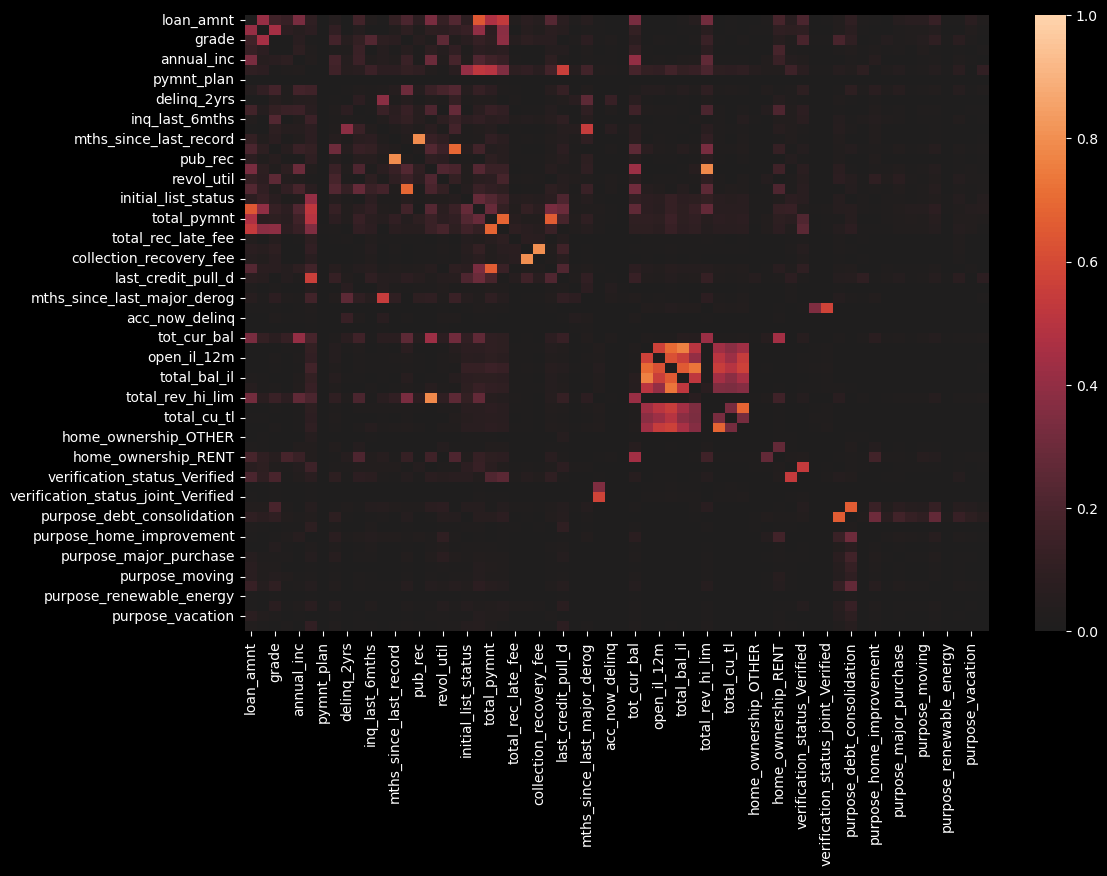

In [59]:
zero_diagonal_heatmap(X_num)

In [60]:
corr_dict(X_num)

{'open_il_6m': 1, 'mths_since_last_record': 1, 'mths_since_rcnt_il': 1, 'total_bal_il': 1, 'max_bal_bc': 1, 'total_rev_hi_lim': 1, 'revol_bal': 1, 'pub_rec': 1, 'collection_recovery_fee': 1, 'recoveries': 1}


In [61]:
corr_list(corr = .7, min_corr=0)

{'open_il_6m': ['total_bal_il'], 'mths_since_last_record': ['pub_rec'], 'mths_since_rcnt_il': ['max_bal_bc'], 'total_bal_il': ['open_il_6m'], 'max_bal_bc': ['mths_since_rcnt_il'], 'total_rev_hi_lim': ['revol_bal'], 'revol_bal': ['total_rev_hi_lim'], 'pub_rec': ['mths_since_last_record'], 'collection_recovery_fee': ['recoveries'], 'recoveries': ['collection_recovery_fee']}


In [62]:
X_num.drop(['open_il_6m', 'mths_since_last_record', 'mths_since_rcnt_il', 'total_rev_hi_lim', 'collection_recovery_fee'], axis = 1, inplace = True)

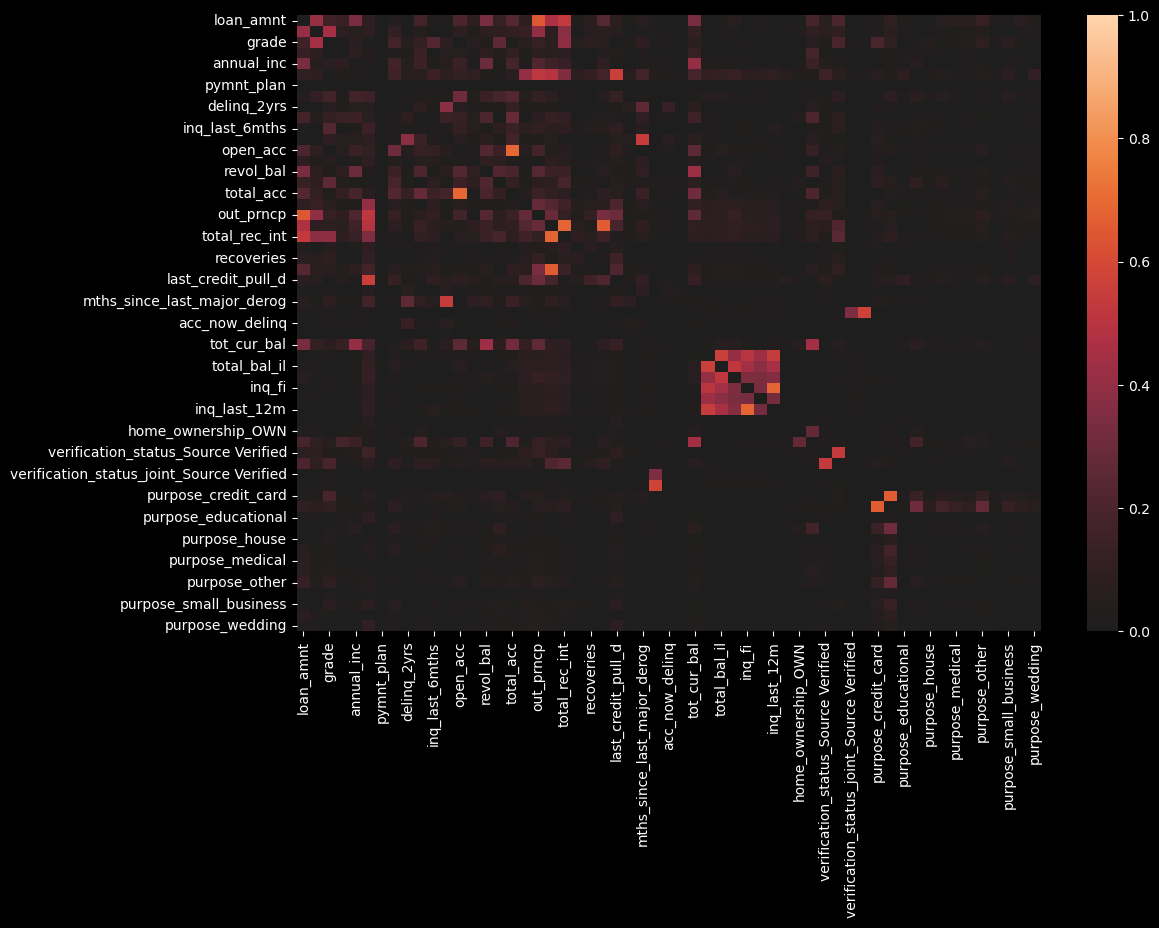

In [63]:
zero_diagonal_heatmap(X_num)

In [64]:
vif(X_num.select_dtypes(include = 'number'))

38 out of 54 features have a vif < 2.5
{'term': 23.953121398345356, 'total_pymnt': 16.539153725333964, 'loan_amnt': 13.595740554297468, 'purpose_debt_consolidation': 13.54993274244892, 'out_prncp': 12.62883823763654, 'total_acc': 12.478163317334545, 'open_acc': 12.40805966442699, 'purpose_credit_card': 11.07580770661303, 'revol_util': 7.762412039212137, 'dti': 7.60439861776537, 'total_rec_int': 5.568249638471533, 'purpose_home_improvement': 3.7690894617799944, 'mths_since_last_delinq': 3.4999927907194723, 'last_pymnt_amnt': 3.38636867858603, 'annual_inc': 3.25809912960463, 'purpose_other': 3.1351619249389127, 'initial_list_status': 2.2654216572791785, 'revol_bal': 2.249330536101566, 'inq_last_12m': 2.1320597343299705, 'inq_fi': 2.0208362470231944, 'purpose_major_purchase': 1.951782496024747, 'open_il_12m': 1.86083277788649, 'tot_cur_bal': 1.8195334643374823, 'dti_joint': 1.8140337274071479, 'total_bal_il': 1.7963039526915456, 'inq_last_6mths': 1.650752781739783, 'verification_status_Ve

In [67]:
corr_dict(X_num, corr = .6)

{'total_pymnt': 2, 'loan_amnt': 1, 'out_prncp': 1, 'purpose_credit_card': 1, 'purpose_debt_consolidation': 1, 'open_acc': 1, 'total_rec_int': 1, 'last_pymnt_amnt': 1, 'inq_last_12m': 1, 'inq_fi': 1, 'total_acc': 1}


In [68]:
corr_list(corr = .6, min_corr = 0)

{'total_pymnt': ['total_rec_int', 'last_pymnt_amnt'], 'loan_amnt': ['out_prncp'], 'out_prncp': ['loan_amnt'], 'purpose_credit_card': ['purpose_debt_consolidation'], 'purpose_debt_consolidation': ['purpose_credit_card'], 'open_acc': ['total_acc'], 'total_rec_int': ['total_pymnt'], 'last_pymnt_amnt': ['total_pymnt'], 'inq_last_12m': ['inq_fi'], 'inq_fi': ['inq_last_12m'], 'total_acc': ['open_acc']}


In [69]:
X_num.drop(['total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'out_prncp', 'open_acc'], axis = 1, inplace = True)

In [71]:
X_num['inquiries'] = X_num[['inq_last_12m', 'inq_fi']].max(axis = 1)
X_num.drop(['inq_last_12m', 'inq_fi'], axis = 1, inplace = True)

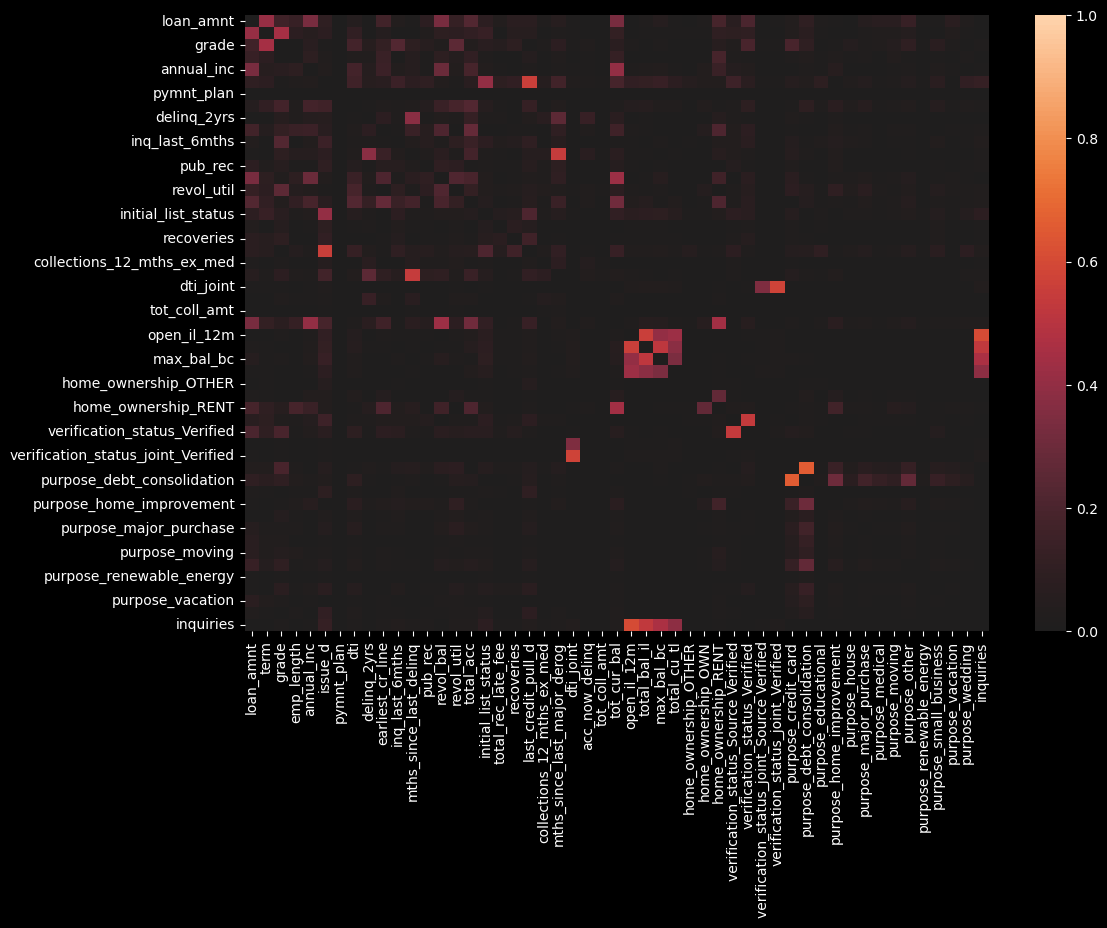

In [72]:
zero_diagonal_heatmap(X_num)

In [74]:
vif(X_num.select_dtypes(include = 'number'))

44 out of 48 features have a vif < 2.5
{'purpose_debt_consolidation': 13.343129651965906, 'purpose_credit_card': 10.920605053388611, 'purpose_home_improvement': 3.7321632290436075, 'purpose_other': 3.1050913203026247, 'purpose_major_purchase': 1.94012815859085, 'open_il_12m': 1.8738802396353609, 'inquiries': 1.827908684868039, 'dti_joint': 1.8133019543296547, 'total_bal_il': 1.8033319035466921, 'tot_cur_bal': 1.799078848812394, 'loan_amnt': 1.6753516465218434, 'verification_status_Verified': 1.6021197106551686, 'verification_status_joint_Verified': 1.594642452429576, 'mths_since_last_delinq': 1.5910644585049512, 'verification_status_Source Verified': 1.5118488095852727, 'max_bal_bc': 1.5104287822563671, 'purpose_small_business': 1.5077176865957334, 'home_ownership_RENT': 1.4556049463038139, 'mths_since_last_major_derog': 1.4543514572387506, 'purpose_medical': 1.4406863516889368, 'revol_bal': 1.4208176513172945, 'annual_inc': 1.387872694485366, 'total_acc': 1.3592955726464613, 'total_cu

In [75]:
X_num.drop('purpose_debt_consolidation', axis = 1, inplace = True)

In [76]:
vif(X_num.select_dtypes(include = 'number'))

47 out of 47 features have a vif < 2.5
{'open_il_12m': 1.8735792442765336, 'inquiries': 1.8273746991183524, 'dti_joint': 1.8132888940474505, 'total_bal_il': 1.8029374755388388, 'tot_cur_bal': 1.7985291461242359, 'loan_amnt': 1.6720162343782636, 'verification_status_joint_Verified': 1.5946401032897581, 'mths_since_last_delinq': 1.591064385472576, 'verification_status_Verified': 1.582559235873461, 'max_bal_bc': 1.510185683481991, 'verification_status_Source Verified': 1.5022305021075908, 'mths_since_last_major_derog': 1.44315726231626, 'revol_bal': 1.4063232144671134, 'home_ownership_RENT': 1.4060920532990842, 'annual_inc': 1.3874985130995106, 'total_acc': 1.3494242095698048, 'total_cu_tl': 1.3096382850719137, 'verification_status_joint_Source Verified': 1.2172551074545133, 'dti': 1.203080748472579, 'delinq_2yrs': 1.1839893619310622, 'home_ownership_OWN': 1.1233919842808255, 'purpose_credit_card': 1.113432144593801, 'initial_list_status': 1.0827692993419606, 'purpose_home_improvement': 1

In [78]:
X_num_num = X_num.select_dtypes(include = 'number')

## <center> **Lasso Regularization**

Lasso Regularization is a technique for variable selection that uses regression to evaluate the effect that features have on a target variable. The idea is to add a penalty term that contains the coefficient or slope of the variables with respect to the target variable multiplied by parameter. 
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha|β| \nonumber
\end{equation}
Where $\beta$ is the coefficient of the feature, SSD is the sum of squared distances of the point to the regression line and $\alpha$ is the penalty’s parameter. If there is more than a single feature, then we can sum the coefficients:
\begin{equation}
Loss(β_1,...β_n) = SSD + \alpha* \sum_{i=1}^{n}|β_i| \nonumber
\end{equation}
Lasso aims to reduce the loss in equation (3). If a feature is not important, then changing its slope will not move the regression line close enough to the data points to decrease the loss function with a non-zero value. If a feature is important, the regression line will move towards the data and minimize the SSD faster than it increases the penalty term. Since only features with non-zero coefficients are meaningful, I can discard all the features with a coefficient of zero. 



First we will run a gridsearch to find the best value of $\alpha$, and then we will use the coeffecients from that value of $\alpha$ to determine which features stay in the model.

In [ ]:
# Create Lasso model
lasso = Lasso(max_iter = 50000)

# Define hyperparameter grid with a value less than 00.5 since that was the be
params = {'alpha': np.linspace(.001, .01, 20)}

# Perform grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=params, cv=8)

# fit the gridsearch of parameters to the data
grid_search.fit(X_num_num, y)

# Print best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

In [ ]:
# Find the coefficients of lasso regularization
lasso = Lasso(alpha = )
# Fit the lasso regularization to the data 
lasso.fit(X_num,y)
# Create a dictionary of all the features and their corresponding lasso coefficients
lasso_dict = {X_num.columns[i]:lasso.coef_[i] for i in range(len(X_num.columns)) if list(lasso.coef_)[i] != 0}
# Create a list of all the features that don't have a lasso coefficient of zero
lasso_features = [X_num.columns[i] for i in range(len(X_num.columns)) if list(lasso.coef_)[i] != 0]
# Print the features and coefficients
print(lasso_dict)
# Print the number of features are left from lasso
print(len(lasso_dict))

In [18]:
y.value_counts(normalize = True)

Current                                                0.678153
Fully Paid                                             0.234086
Charged Off                                            0.050991
Late (31-120 days)                                     0.013062
Issued                                                 0.009534
In Grace Period                                        0.007047
Late (16-30 days)                                      0.002656
Does not meet the credit policy. Status:Fully Paid     0.002240
Default                                                0.001374
Does not meet the credit policy. Status:Charged Off    0.000858
Name: loan_status, dtype: float64